<a href="https://colab.research.google.com/github/yeesem/Deep_Learning/blob/main/Breast_Cancer_Prediction_Custom_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [63]:
!pip install ucimlrepo

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
from ucimlrepo import fetch_ucirepo

# Load and Preprocess the Dataset

In [145]:
# fetch dataset
breast_cancer_wisconsin_original = fetch_ucirepo(id=15)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_original.data.features
y = breast_cancer_wisconsin_original.data.targets

df = pd.concat([X, y], axis=1)

In [146]:
# X.pop('id')

In [147]:
# df = df[df["Bare_nuclei"] != '?' ]
df.dropna(inplace = True)
df.Bare_nuclei = pd.to_numeric(df.Bare_nuclei)

<Axes: >

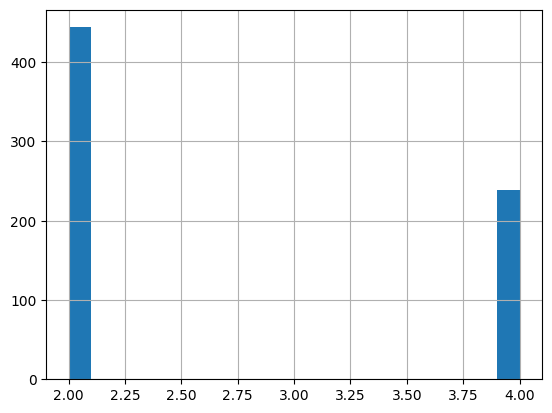

In [148]:
df['Class'].hist(bins=20)

In [149]:
# if == 2, True = 0, False = 1
df['Class'] = np.where(df['Class'] == 2, 0, 1)
df.head()

,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses,Class
0,5,1,1,1,2,1.0,3,1,1,0
1,5,4,4,5,7,10.0,3,2,1,0
2,3,1,1,1,2,2.0,3,1,1,0
3,6,8,8,1,3,4.0,3,7,1,0
4,4,1,1,3,2,1.0,3,1,1,0


In [150]:
train, test = train_test_split(df, test_size = 0.2)

In [151]:
train_stats = train.describe()
train_stats.pop('Class')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Clump_thickness,546.0,4.448718,2.826176,1.0,2.0,4.0,6.0,10.0
Uniformity_of_cell_size,546.0,3.168498,3.079526,1.0,1.0,1.0,5.0,10.0
Uniformity_of_cell_shape,546.0,3.236264,2.995569,1.0,1.0,1.0,5.0,10.0
Marginal_adhesion,546.0,2.838828,2.870865,1.0,1.0,1.0,4.0,10.0
Single_epithelial_cell_size,546.0,3.225275,2.230436,1.0,2.0,2.0,4.0,10.0
Bare_nuclei,546.0,3.483516,3.596214,1.0,1.0,1.0,5.0,10.0
Bland_chromatin,546.0,3.419414,2.455084,1.0,2.0,3.0,4.0,10.0
Normal_nucleoli,546.0,2.956044,3.104582,1.0,1.0,1.0,4.0,10.0
Mitoses,546.0,1.644689,1.814857,1.0,1.0,1.0,1.0,10.0


In [152]:
train_Y = train.pop("Class")
test_Y = test.pop("Class")

In [153]:
test_Y.values

array([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0])

In [154]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [155]:
norm_train_X = norm(train)
norm_test_X = norm(test)

In [156]:
norm_train_X.values

array([[ 0.5488978 , -0.70416612, -0.74652381, ..., -0.98547081,
        -0.6300506 , -0.35522836],
       [ 0.19506285,  0.27000965,  0.25495531, ...,  0.64380114,
         0.98047201, -0.35522836],
       [-0.51260703, -0.70416612, -0.74652381, ..., -0.17083483,
        -0.6300506 , -0.35522836],
       ...,
       [-0.15877209, -0.70416612, -0.41269744, ..., -0.57815282,
        -0.6300506 , -0.35522836],
       [ 1.96423757,  0.5947349 ,  1.25643443, ...,  1.86575511,
         1.94678557, -0.35522836],
       [-0.15877209, -0.70416612, -0.74652381, ..., -0.17083483,
        -0.6300506 , -0.35522836]])

In [157]:
train_dataset = tf.data.Dataset.from_tensor_slices((norm_train_X.values, train_Y.values))
test_dataset = tf.data.Dataset.from_tensor_slices((norm_test_X.values, test_Y.values))

In [158]:
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train)).batch(batch_size)

test_dataset =  test_dataset.batch(batch_size=batch_size)

In [159]:
a = enumerate(train_dataset)

print(len(list(a)))

18


# Define the Model

In [160]:
def base_model():
    inputs = tf.keras.layers.Input(shape=(len(train.columns)))

    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = base_model()

# Define Optimizer and Loss

In [161]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss_object = tf.keras.losses.BinaryCrossentropy()

# Evaluate Untrained Model

In [162]:
# Calculate the loss on the model before training begins.
outputs = model(norm_test_X.values)
outputs = np.squeeze(outputs)

loss_value = loss_object(y_true=test_Y.values, y_pred= outputs)
print("Loss before training %.4f" % loss_value.numpy())

Loss before training 0.6697


In [163]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

<ipython-input-163-b043df30f57b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-163-b043df30f57b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


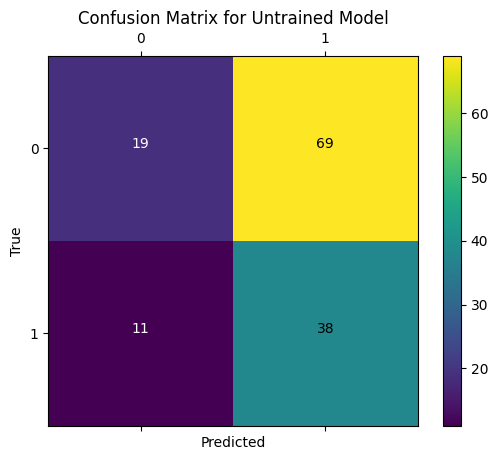

In [164]:
plot_confusion_matrix(test_Y.values, tf.round(outputs), title='Confusion Matrix for Untrained Model')

In [165]:
class F1Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        '''initializes attributes of the class'''

        # call the parent class init
        super(F1Score, self).__init__(name=name, **kwargs)

        # Initialize Required variables
        # true positives
        self.tp = tf.Variable(0, dtype = 'int32')
        # false positives
        self.fp = tf.Variable(0, dtype = 'int32')
        # true negatives
        self.tn = tf.Variable(0, dtype = 'int32')
        # false negatives
        self.fn = tf.Variable(0, dtype = 'int32')

    def update_state(self, y_true, y_pred, sample_weight=None):
        '''
        Accumulates statistics for the metric

        Args:
            y_true: target values from the test data
            y_pred: predicted values by the model
        '''

        # Calulcate confusion matrix.
        conf_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=2)

        # Update values of true positives, true negatives, false positives and false negatives from confusion matrix.
        self.tn.assign_add(conf_matrix[0][0])
        self.tp.assign_add(conf_matrix[1][1])
        self.fp.assign_add(conf_matrix[0][1])
        self.fn.assign_add(conf_matrix[1][0])

    def result(self):
        '''Computes and returns the metric value tensor.'''

        # Calculate precision
        if (self.tp + self.fp == 0):
            precision = 1.0
        else:
            precision = self.tp / (self.tp + self.fp)

        # Calculate recall
        if (self.tp + self.fn == 0):
            recall = 1.0
        else:
            recall = self.tp / (self.tp + self.fn)

        # Return F1 Score
        ### START CODE HERE ###
        f1_score = 2 * ((precision * recall) / (precision + recall))
        ### END CODE HERE ###

        return f1_score

    def reset_states(self):
        '''Resets all of the metric state variables.'''

        # The state of the metric will be reset at the start of each epoch.
        self.tp.assign(0)
        self.tn.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)


In [166]:
train_f1score_metric = F1Score()
val_f1score_metric = F1Score()

train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

In [167]:
def apply_gradient(optimizer, loss_object, model, x, y):

    with tf.GradientTape() as tape:
        logits = model(x)
        loss_value = loss_object(y_true = y,y_pred = logits)

    gradients = tape.gradient(loss_value,model.trainable_weights)
    optimizer.apply_gradients(zip(gradients,model.trainable_weights))

    return logits, loss_value

In [168]:
def train_data_for_one_epoch(train_dataset, optimizer, loss_object, model,
                             train_acc_metric, train_f1score_metric, verbose=True):

    losses = []

    #Iterate through all batches of training data
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        #Calculate loss and update trainable variables using optimizer
        logits, loss_value = apply_gradient(optimizer, loss_object, model, x_batch_train, y_batch_train)
        losses.append(loss_value)

        #Round off logits to nearest integer and cast to integer for calulating metrics
        logits = tf.round(logits)
        logits = tf.cast(logits, 'int64')

        #Update the training metrics
        train_acc_metric.update_state(y_batch_train, logits)
        train_f1score_metric.update_state(y_batch_train, logits)

        #Update progress
        if verbose:
            print("Training loss for step %s: %.4f" % (int(step), float(loss_value)))

    return losses

In [169]:
def perform_validation():
    losses = []

    #Iterate through all batches of validation data.
    for x_val, y_val in test_dataset:

        #Calculate validation loss for current batch.
        val_logits = model(x_val)
        val_loss = loss_object(y_true=y_val, y_pred=val_logits)
        losses.append(val_loss)

        #Round off and cast outputs to either  or 1
        val_logits = tf.cast(tf.round(model(x_val)), 'int64')

        #Update validation metrics
        val_acc_metric.update_state(y_val, val_logits)
        val_f1score_metric.update_state(y_val, val_logits)

    return losses

In [170]:
# Iterate over epochs.
epochs = 5
epochs_val_losses, epochs_train_losses = [], []

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    #Perform Training over all batches of train data
    losses_train = train_data_for_one_epoch(train_dataset, optimizer, loss_object, model, train_acc_metric, train_f1score_metric)

    # Get results from training metrics
    train_acc = train_acc_metric.result()
    train_f1score = train_f1score_metric.result()

    #Perform validation on all batches of test data
    losses_val = perform_validation()

    # Get results from validation metrics
    val_acc = val_acc_metric.result()
    val_f1score = val_f1score_metric.result()

    #Calculate training and validation losses for current epoch
    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)

    print('\n Epcoh %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f, Train F1 Score: %.4f, Validation F1 Score: %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc), train_f1score, val_f1score))

    #Reset states of all metrics
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()
    val_f1score_metric.reset_states()
    train_f1score_metric.reset_states()

Start of epoch 0
Training loss for step 0: 0.6382
Training loss for step 1: 0.5146
Training loss for step 2: 0.4889
Training loss for step 3: 0.4135
Training loss for step 4: 0.3986
Training loss for step 5: 0.3217
Training loss for step 6: 0.3544
Training loss for step 7: 0.2881
Training loss for step 8: 0.2525
Training loss for step 9: 0.3108
Training loss for step 10: 0.2252
Training loss for step 11: 0.1836
Training loss for step 12: 0.2102
Training loss for step 13: 0.1525
Training loss for step 14: 0.1683
Training loss for step 15: 0.1656
Training loss for step 16: 0.2430
Training loss for step 17: 0.2079

 Epcoh 0: Train loss: 0.3077  Validation Loss: 0.1277, Train Accuracy: 0.9432, Validation Accuracy 0.9781, Train F1 Score: 0.9231, Validation F1 Score: 0.9691
Start of epoch 1
Training loss for step 0: 0.1239
Training loss for step 1: 0.1044
Training loss for step 2: 0.1440
Training loss for step 3: 0.1692
Training loss for step 4: 0.2337
Training loss for step 5: 0.1035
Traini

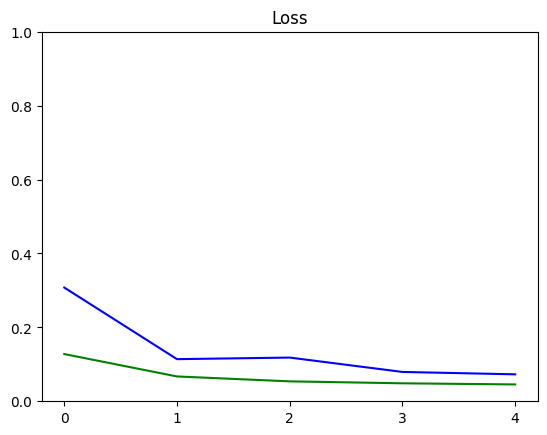

In [171]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric,color='blue',label=metric_name)
    plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

<ipython-input-163-b043df30f57b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-163-b043df30f57b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


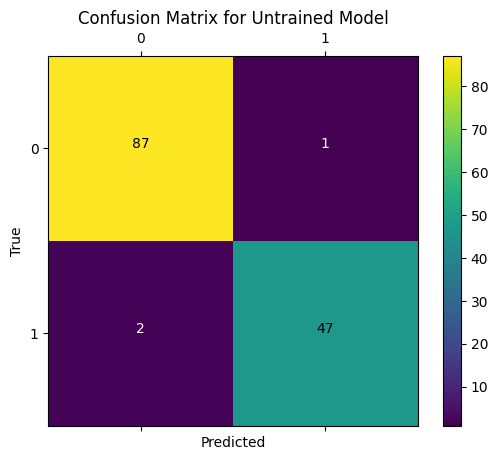

In [172]:
test_outputs = model(norm_test_X.values)
plot_confusion_matrix(test_Y.values, tf.round(test_outputs), title='Confusion Matrix for Untrained Model')